# Data Analysis

In [1]:
import numpy as np

import matplotlib.pyplot as plt

from pathlib import Path
pathtohere = Path()

In [2]:
fineStructure = 1. / 137. ## Cite a better value for this.
LHC_s = (8e+3)**2 # [GeV^2] ## Cite a better value of this from  the W boson ATLAS paper. 
CKM = np.asarray([[0.97373, 0.2243, 0.00382], [0.221, 0.975, 0.0408], [0.0086, 0.0415, 1.014]]) ## Again cite
fermiConstant = 1.1663787e-5 # Cite
sin2WeinbergAngle = 0.22290 # Cite

In [3]:
def read_data(file:str):
    """
    Read a given data file.
    
    Inputs:
        - file:str: Filename.
        
    Outputs:
        - xs:np.ndarray: Momentum fractions.
        - data:np.ndarray: PDFs.
        - qs:np.ndarray: Q^2 used.
    """
    
    # Get data from file for x1.
    data_all = np.loadtxt(pathtohere / file, dtype=str)
    whereNan = np.where('-nan(ind)'==data_all)
    data_all[whereNan] = '0.'
    data_all = data_all.astype(float)
    
    # Split into different Q^2
    qs = np.asarray([80.,91.,12.,60.,200.,650.])
    numQ = int(qs.shape[0])
    numX = int(data_all.shape[0]/numQ)
    data = np.empty((numQ,numX,data_all.shape[1]),dtype=float)
    for i in range(numQ):
        data[i,:,:] = data_all[i*numX:(i+1)*numX]
        
    xs = data[:,:,0]

    
    data = data[:,:,1:]
    
    return xs, data, qs


In [4]:
def display_PDFs(xs:np.ndarray, data:np.ndarray, headings:tuple,colours:tuple,q2:float):
    """
    Display the PDFs.
    
    Inputs:
        - xs:np.ndarray: Momentum fractions the PDFs are evaluated at.
        - data:np.ndarray: 2D array of PDFs of each used quark at all x.
        - headings:tuple: Quark types used.
        - colours:tuple: Graph colours.
        - qs:float: Q^2 evaluated at.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    
    for i,heading in enumerate(headings):
        ax.plot(xs, data[:, i], label=heading,c=colours[i],marker='.')
        ax.grid()
    
    # Create appropiate labels.
    ax.set_xlabel('momentum fraction / x')
    ax.set_ylabel(r'PDF / $f_i(x)$')
    ax.set_title(r'$Q^2$ =' + str(q2))
    
    ax.legend(loc='best')
    ax.set_xscale('log')
    
    plt.show()
    
    
    
def display_fortran_c_error(data_c:np.ndarray, data_f:np.ndarray,
                            xs:np.ndarray,headings:tuple,colours:tuple,
                           q2:float):
    """
    Error of C translated code to Fortran (hopefully zero).
    
    Inputs:
        - data_c:np.ndarray: Data obtained from C++ code.
        - data_f:np.ndarray: Data obtained from Fortran code.
        - xs:np.ndarray: Momentum fraction evaluated at.
        - headings:tuple: Quark types used.
        - colours:tuple: Graph colours.
        - qs:float: Q^2 evaluated at.
    """
    
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot()
    
    for i,heading in enumerate(headings):
        ax.plot(xs, data_c[:, i] - data_f[:,i], label=heading,c=colours[i],marker='.')
        ax.grid()
        
    ax.axhspan(-1e-6, 1e-6,
                    alpha=0.2, color='r')
    
    # Create appropiate labels.
    ax.set_xlabel('momentum fraction / x')
    ax.set_ylabel(r'PDF difference / $\Delta f_i(x)$')
    ax.set_title(r'$Q^2$ =' + str(q2))
    
    ax.legend(loc='best')
    ax.set_xscale('log')
    
    plt.show()

In [5]:
def calculate_crossSection(WmassSqrd:float, ZmassSqrd:float, x1:np.ndarray, x2_W:np.ndarray,
                           x2_Z:np.ndarray,
                             data1_W:np.ndarray, data2_W:np.ndarray, data1_Z:np.ndarray,
                          data2_Z:np.ndarray):
    """
    Calculate the cross section of Drell-Yan boson production.
    
    Inputs:
        - WmassSqrd:float: Square mass of the W boson in the C++ code [GeV].
        - ZmassSqrd:float: Square mass of the Z boson in the C++ code [GeV].
        - x1:np.ndarray: Momentum fractions used for proton 1.
        - x2_W:np.ndarray: Momentum fractions used for proton 2 for W production.
        - x2_Z:np.ndarray: Momentum fractions used for proton 2 for Z production.
        - data1_W:np.ndarray: PDF values for all x1 for the single WmassSqrd value.
        - data2_W:np.ndarray: PDF values for all x2 for the single WmassSqrd value.
        - data1_Z:np.ndarray: PDF values for all x1 for the single ZmassSqrd value.
        - data2_Z:np.ndarray: PDF values for all x2 for the single ZmassSqrd value.

    """
    numX = x1.shape[0]
    
    sigma0 = 4.*np.pi*fineStructure*fineStructure / (3.*WmassSqrd)
    np.testing.assert_allclose(x2_W, WmassSqrd / (x1*LHC_s))
    
    rapidities_W = 0.5 * np.log(x2_W / x1)
    rapidities_Z = 0.5 * np.log(x2_Z / x1)
    
    numUpType = 2
    upCharge = 2. / 3.
    numDownType = 3
    downCharge = -1./3.
    
    upTypePDFs = np.asarray([data1_W[:, :2], data2_W[:, :2]])
    downTypePDFs = np.asarray([data1_W[:, 2:5], data2_W[:, 2:5]])
    upTypeBarPDFs = np.asarray([data1_W[:, 5:7], data2_W[:, 5:7]])
    downTypeBarPDFs = np.asarray([data1_W[:, 7:10], data2_W[:, 7:10]])
    
    # Photon
    integrand = np.zeros(numX)
    for i in range(2):
        integrand += upCharge*upCharge * np.sum(upTypePDFs[i] * upTypeBarPDFs[1-i], axis=1)
        integrand += downCharge*downCharge * np.sum(downTypePDFs[i] * downTypeBarPDFs[1-i], axis=1)

        
    integral = -np.sum((integrand[:-1] + integrand[1:])*(rapidities_W[1:] - rapidities_W[:-1]) / 2.)
    integral *= sigma0 / (3.*LHC_s)
    print(f'Photon contribution: {integral}')
    
    # W boson
    integrand = np.zeros(numX)
    for i in range(numUpType):
        for j in range(numDownType):
            poisson = np.zeros(numX)
            for k in range(2):
                poisson += upTypePDFs[k,:,i] * downTypeBarPDFs[1-k,:,j]
                
            integrand += CKM[i,j] * poisson
            
    integrand *= np.pi/3.*np.sqrt(2.) * fermiConstant*WmassSqrd
    
    integral = -np.sum((integrand[:-1] + integrand[1:])*(rapidities_W[1:] - rapidities_W[:-1]) / 2.)
    integral *= sigma0 / (3.*LHC_s)
    integral *= 1e+9*0.3894 # [GeV^-2 -> pb]
    print(f'W contribution: {integral} [pb]')
    
    # Z boson
    upTypePDFs = np.asarray([data1_Z[:, :2], data2_Z[:, :2]])
    downTypePDFs = np.asarray([data1_Z[:, 2:5], data2_Z[:, 2:5]])
    upTypeBarPDFs = np.asarray([data1_Z[:, 5:7], data2_Z[:, 5:7]])
    downTypeBarPDFs = np.asarray([data1_Z[:, 7:10], data2_Z[:, 7:10]])
    
    
    integrand = np.zeros(numX)
    # Up
    V_q = 0.5 - 2.*upCharge*sin2WeinbergAngle
    A_q = 0.5
    poisson = np.zeros(numX)
    for k in range(2):
        poisson += upTypePDFs[k,:,0]*upTypeBarPDFs[1-k,:,0]
    integrand += (V_q*V_q + A_q*A_q)*poisson
    
    # Down
    V_q = -0.5 - 2.*downCharge*sin2WeinbergAngle
    A_q = -0.5
    poisson = np.zeros(numX)
    for k in range(2):
        poisson += downTypePDFs[k,:,0]*downTypeBarPDFs[1-k,:,0]
    integrand += (V_q*V_q + A_q*A_q)*poisson
    
    # Other
    V_q = -2.*sin2WeinbergAngle
    for i in range(2):
        integrand += V_q*V_q*upCharge*upCharge * np.sum(upTypePDFs[i,:,1:] * upTypeBarPDFs[1-i,:,1:], axis=1)
        integrand += V_q*V_q*downCharge*downCharge * np.sum(downTypePDFs[i,:,1:] * downTypeBarPDFs[1-i,:,1:], axis=1)
    
    integrand *= np.pi/3.*np.sqrt(2.) * fermiConstant*ZmassSqrd

    integral = -np.sum((integrand[:-1] + integrand[1:])*(rapidities_Z[1:] - rapidities_Z[:-1]) / 2.)
    integral *= sigma0 / (3.*LHC_s) * WmassSqrd / ZmassSqrd
    integral *= 1e+9*0.3894 # [GeV^-2 -> pb]
    print(f'Z contribution: {integral} [pb]')

    

In [6]:
def main():
    x1s, data1, qs = read_data('data/partonfrac1.out')
    x2s, data2, qs = read_data('data/partonfrac2.out')
    
    
#     # Get Fortran data for error comparison (bug detection).
#     data_all_f = np.loadtxt(pathtohere / 'data/partonfrac_f.out',dtype=str)
#     whereNan = np.where('NaN'==data_all_f)
#     data_all_f[whereNan] = '0.'
#     data_all_f = data_all_f.astype(float)
    
#     # Split into different Q^2
#     data_f = np.empty((numQ,numX,data_all_f.shape[1]),dtype=float)
#     for i in range(numQ):
#         data_f[i,:,:] = data_all_f[i*numX:(i+1)*numX]
#     data_f = data_f[:,:,1:]

    
    headings = ('up','down','charm', 'strange','bottom','ubar','dbar','cbar',
                'sbar','bbar','g')
    colours = ('r','g','orange','b','k','c','y','pink','m','purple','lime')
    
    
    
    for i in range(qs.shape[0]):
        display_PDFs(x1s[i],data1[i],headings,colours,qs[i])
        display_PDFs(x2s[i],data2[i],headings,colours,qs[i])
        # display_PDFs(xs,data_f[i],headings,colours,qs[i])
        
        # display_fortran_c_error(data[i],data_f[i],xs,headings,colours,qs[i])
        
        
    indexW = 0
    indexZ = 1
    calculate_crossSection(qs[indexW]*qs[indexW], qs[indexZ]*qs[indexZ],
                             x1s[0], x2s[0], x2s[1], data1[indexW], data2[indexW], data1[indexZ], data2[indexZ])
    
    
    

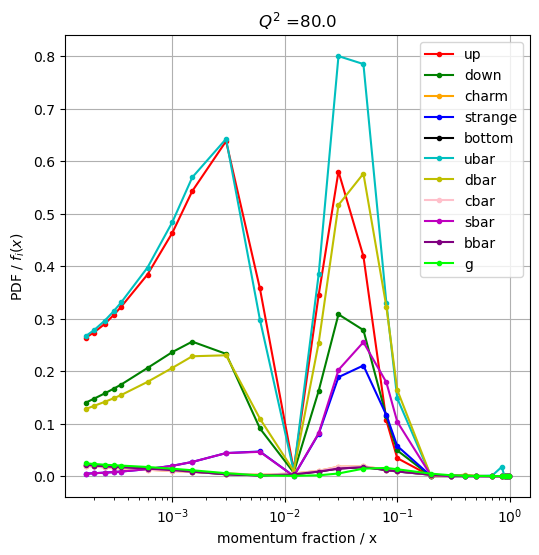

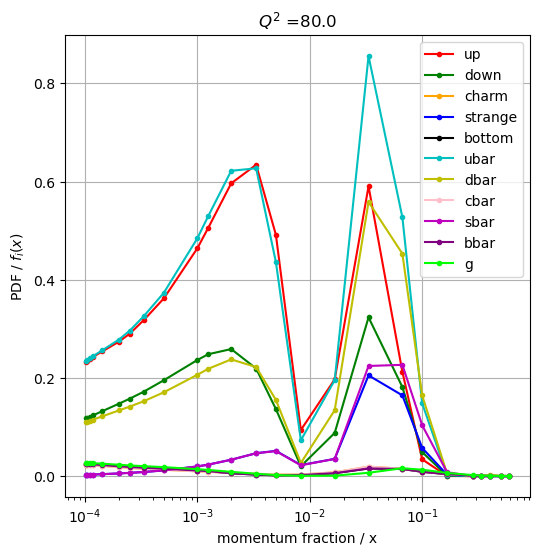

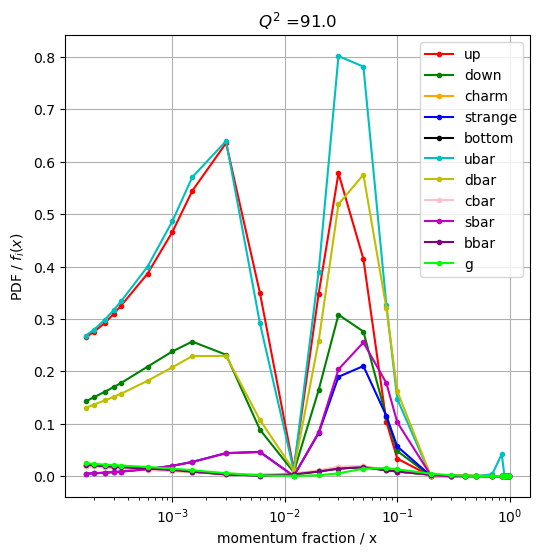

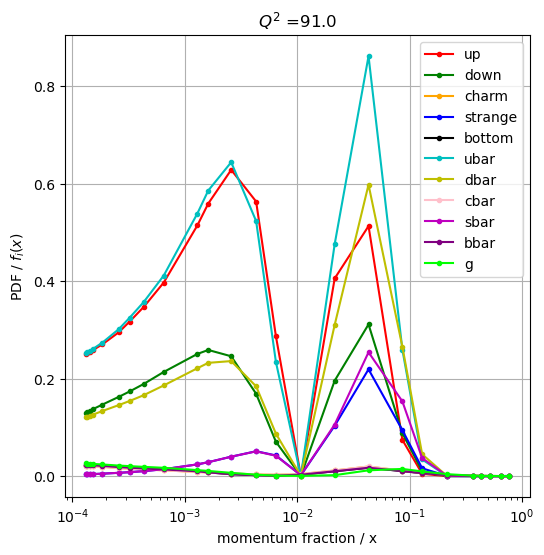

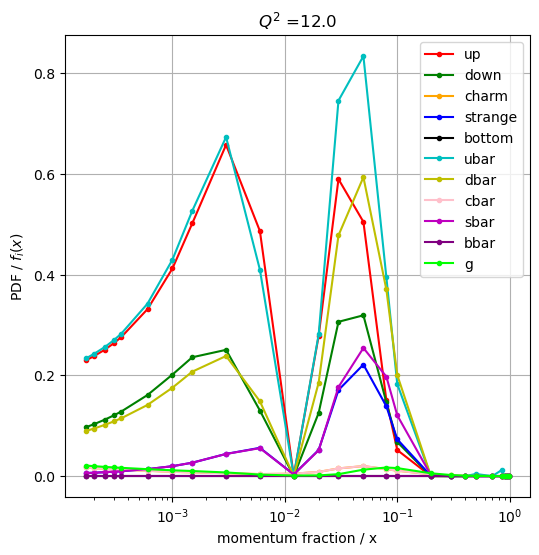

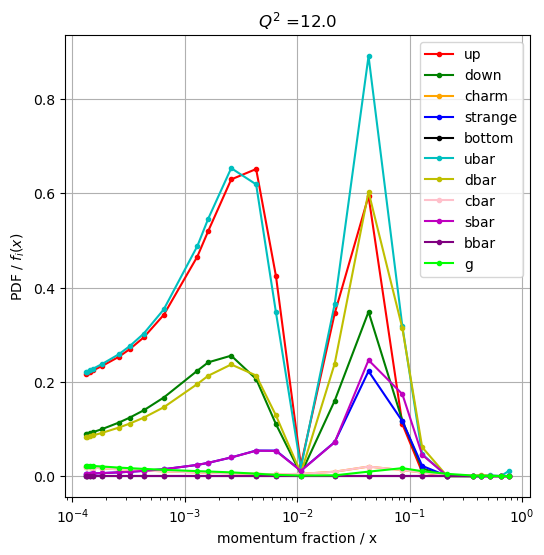

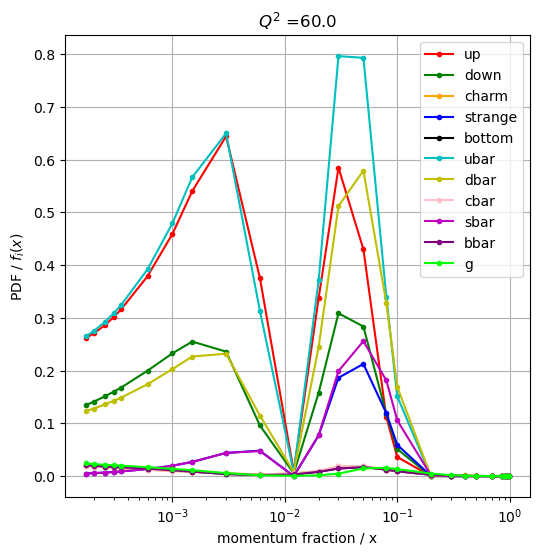

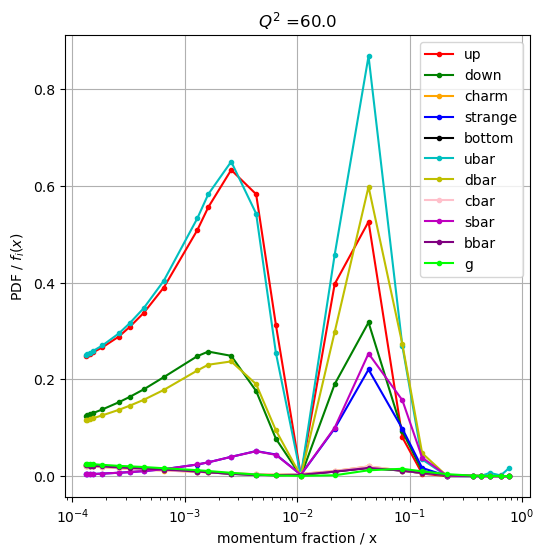

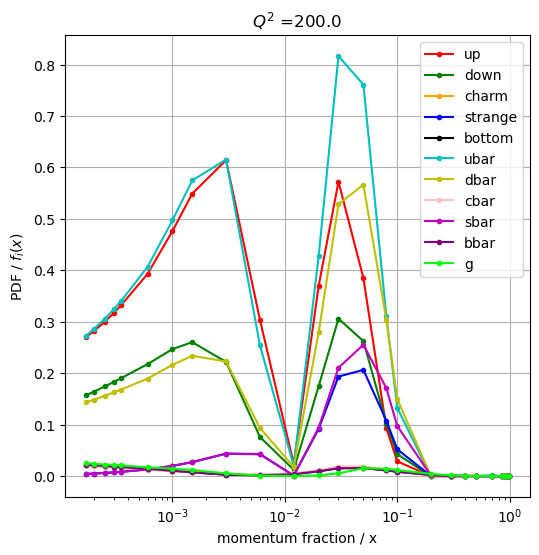

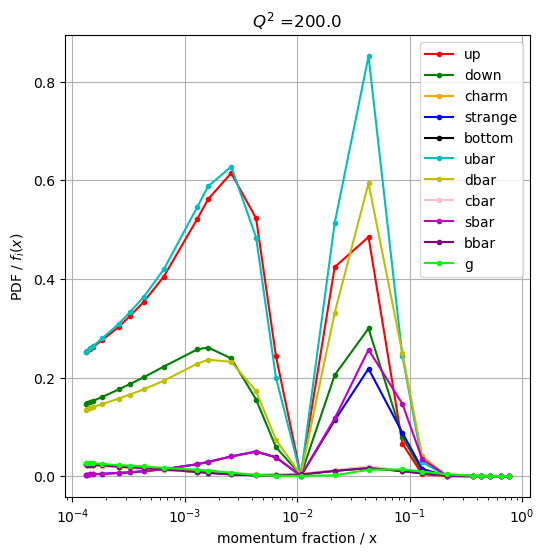

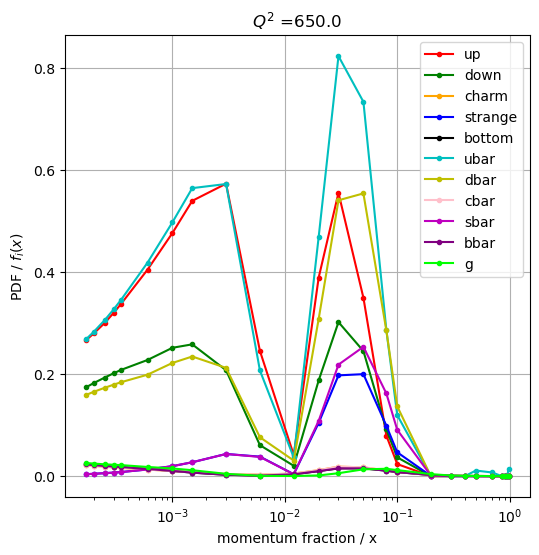

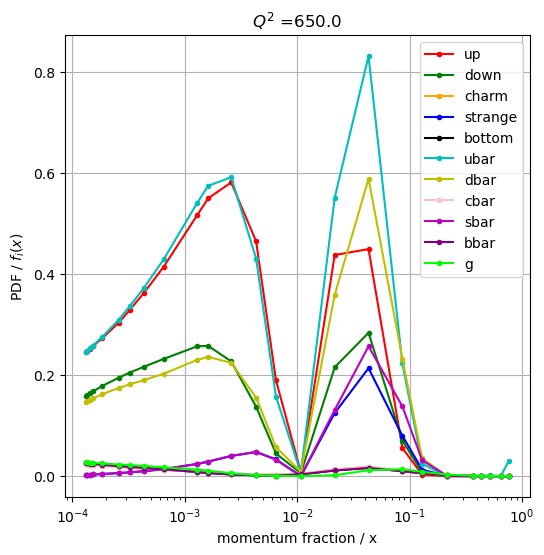

Photon contribution: 2.082194109106314e-16
W contribution: 2.6980466394488757e-09 [pb]
Z contribution: 4.548647333522171e-09 [pb]


In [7]:
if __name__=='__main__':
    main()

In [8]:
91**2/(7e+3)**2 / 1.7e-4

0.9941176470588234

Calculate rapidity dependence.

PDF at two x.

Product two x